#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
! pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import (
    train_test_split, 
    TimeSeriesSplit,
    cross_val_score, 
    GridSearchCV
)

from sklearn.linear_model import LinearRegression 
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, make_scorer 

import warnings

In [3]:
warnings.simplefilter("ignore")

In [4]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Проверим датасет на пропущенные значения и расположение в хронологическом порядке:

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.isnull().mean()

num_orders    0.0
dtype: float64

In [7]:
df.index.is_monotonic

True

**Вывод:** данные расположены в хронологическом порядке и без пропусков.

Рэсемплируем данные по одному часу:

In [8]:
df = df.resample('1H').sum()

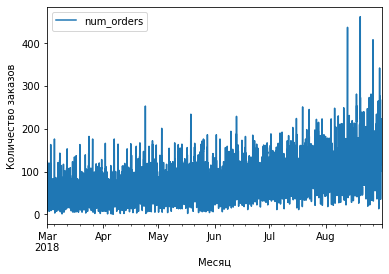

In [9]:
df.plot()
plt.xlabel("Месяц")
plt.ylabel("Количество заказов")
None

In [10]:
df.shape

(4416, 1)

In [11]:
print(f'Начало наблюдений: {df.index.min()}')
print(f'Конец наблюдений: {df.index.max()}')
print(f'Общее время наблюдений: {df.index.max() - df.index.min()}')

Начало наблюдений: 2018-03-01 00:00:00
Конец наблюдений: 2018-08-31 23:00:00
Общее время наблюдений: 183 days 23:00:00


In [12]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Вывод:** данные представлены за 6 месяцев наблюдений.
* Минимальное кол-во заказов - 0;
* Максимальное - 462;
* Медианным значением явлется - 78 заказов.

## Анализ

Попробуем отметить определенные закономерности:

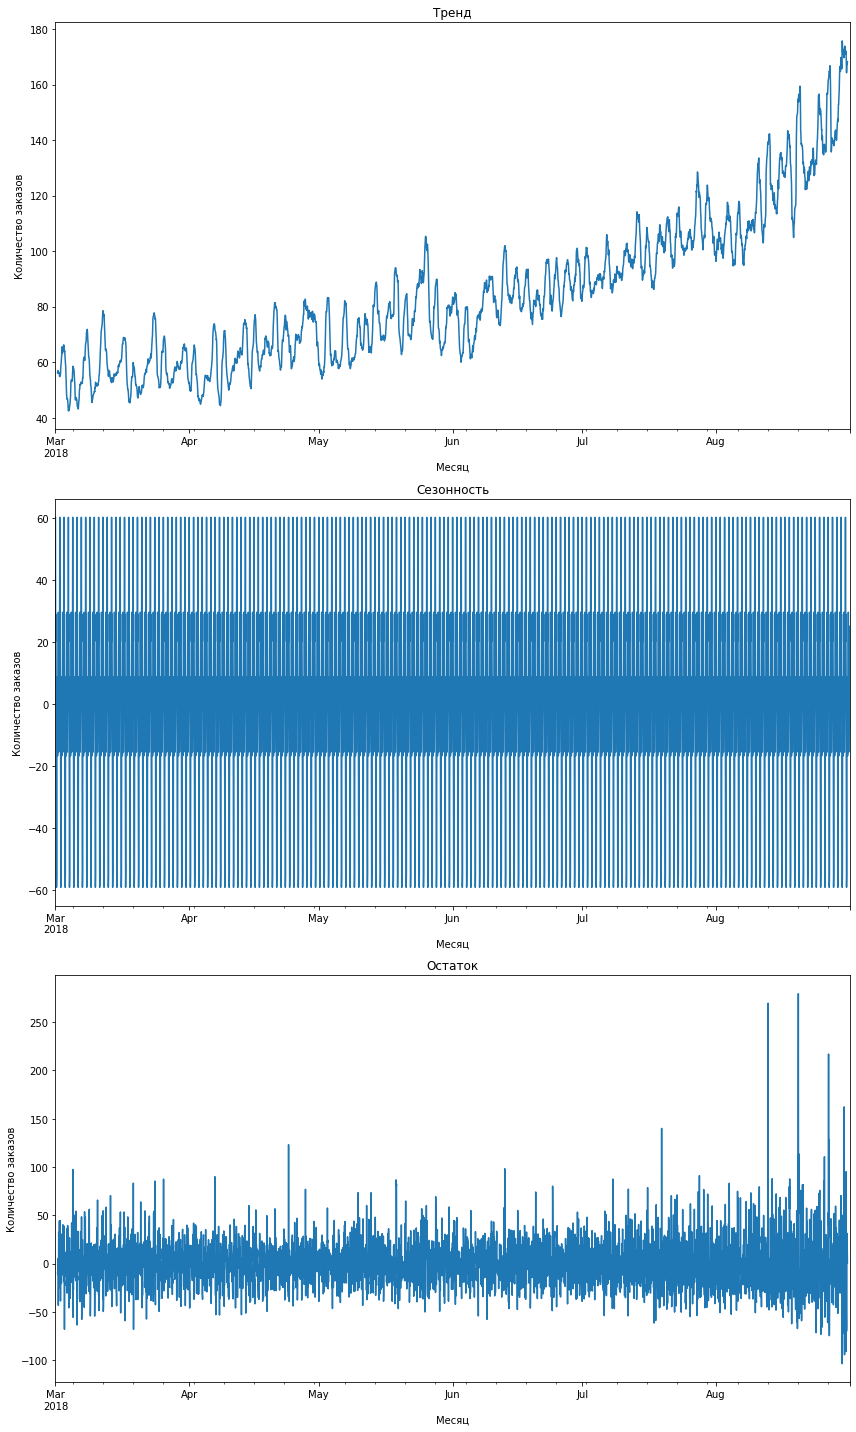

In [13]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel("Месяц")
plt.ylabel("Количество заказов")
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel("Месяц")
plt.ylabel("Количество заказов")
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel("Месяц")
plt.ylabel("Количество заказов")
plt.title('Остаток')
plt.tight_layout()

**Вывод:** на протяжении всех наблюдений отмечается восходящий тренд по количеству заказов. Особенно он заметен с августа. Также отмечена сезонность, но из-за частоты наблюдений ее тяжело интерпретировать. 

Для определения сезонности, возьмем отрезок наблюдений в 1 неделю:
(В 2018 году 2 июля был понедельник)

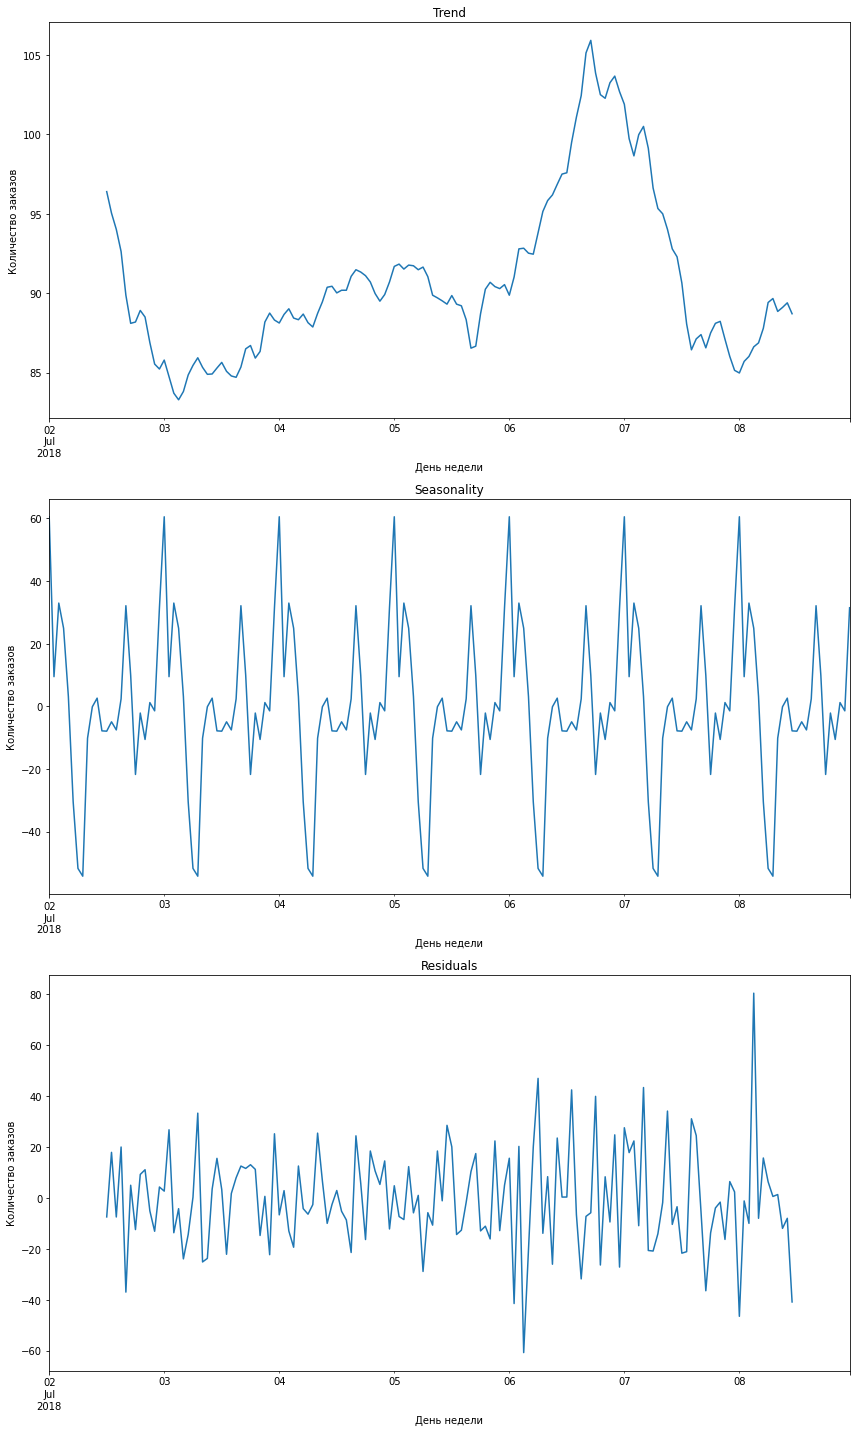

In [14]:
decomposed = seasonal_decompose(df['2018-07-02':'2018-07-08'])

plt.figure(figsize=(12, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.xlabel("День недели")
plt.ylabel("Количество заказов")
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlabel("День недели")
plt.ylabel("Количество заказов")
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel("День недели")
plt.ylabel("Количество заказов")
plt.title('Residuals')
plt.tight_layout()

**Вывод:** 
* рост заказов начинается с пятницы и заканчивается в понедельник;
* количество заказов увеличивается в вечернее время.

## Обучение

Для предсказаний мы будем использовать две модели: `Линейная регрессия` и `Catboost Regressor`

Создадим признаки для обучения:

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()

In [16]:
make_features(df, 24, 48)

In [17]:
df = df.dropna()

In [18]:
df

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,5,0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,59.791667
2018-03-03 01:00:00,108,5,1,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,60.604167
2018-03-03 02:00:00,25,5,2,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,61.083333
2018-03-03 03:00:00,64,5,3,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,60.125000
2018-03-03 04:00:00,44,5,4,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,170.895833
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,170.208333
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,169.437500


Создадим выборки и выделим признаки:

In [19]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3931, 27), (3931,), (437, 27), (437,))

Создадим функцию для оценки модели:

In [21]:
def print_metric(y, y_pred):
    return print(f'RMSE: {np.sqrt((mean_squared_error(y, y_pred)))}')

RMSE = make_scorer(print_metric, greater_is_better=False)

### Линейная регрессия

In [22]:
%%time
cross_val = TimeSeriesSplit(n_splits=8).split(X_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

lr_cv_score = (cross_val_score(lr, X_train, y_train, scoring=RMSE, cv=cross_val))

RMSE: 22.803350955115302
RMSE: 24.59094846846162
RMSE: 24.10418448835396
RMSE: 26.089264898025533
RMSE: 24.976878770290195
RMSE: 26.768541867012292
RMSE: 30.63410101443559
RMSE: 34.34746163083874
CPU times: user 528 ms, sys: 872 ms, total: 1.4 s
Wall time: 1.35 s


### Catboost

In [23]:
%%time
cross_val = TimeSeriesSplit(n_splits=8).split(X_train)
cb = CatBoostRegressor()

cb_parametrs = {
    'learning_rate': [0.02, 0.05, 0.1],
    'depth': [3, 7, 10]
               }

cb_grid = GridSearchCV(
    cb, 
    cb_parametrs, 
    scoring=RMSE, 
    cv=cross_val)
cb_grid.fit(X_train, y_train, verbose=0)

RMSE: 20.559514811554653
RMSE: 22.090837101934007
RMSE: 21.678147962278274
RMSE: 23.571164981428847
RMSE: 22.559361540379815
RMSE: 23.835865404738694
RMSE: 27.678542694194288
RMSE: 32.633991336807426
RMSE: 21.370417767806188
RMSE: 22.39255014777532
RMSE: 22.047610983610596
RMSE: 23.103363772265844
RMSE: 22.68092816495252
RMSE: 23.38139517948303
RMSE: 27.023708927022476
RMSE: 32.18666061966734
RMSE: 21.96288838290843
RMSE: 22.742491482154385
RMSE: 22.292565123187583
RMSE: 23.204447373324573
RMSE: 22.64400519570951
RMSE: 23.30403969543608
RMSE: 27.180881902905963
RMSE: 32.566689823820305
RMSE: 19.924305187826313
RMSE: 21.431045387951784
RMSE: 21.23392035153496
RMSE: 23.01513819030119
RMSE: 22.490410588177586
RMSE: 23.201696339378064
RMSE: 27.317692667909867
RMSE: 31.866957528029836
RMSE: 20.149943026857667
RMSE: 21.915219415953437
RMSE: 21.45497859042766
RMSE: 22.801126074885563
RMSE: 22.373871768660724
RMSE: 23.404784827320473
RMSE: 26.774711254047975
RMSE: 31.89234212298794
RMSE: 20.43

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7ff230ef5740>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7ff230f09970>,
             param_grid={'depth': [3, 7, 10],
                         'learning_rate': [0.02, 0.05, 0.1]},
             scoring=make_scorer(print_metric, greater_is_better=False))

In [24]:
cb_grid.best_params_

{'depth': 3, 'learning_rate': 0.02}

**Вывод:** методами кросс-валидации мы определили лучшие гиперпарметры для Catboost.

## Тестирование

In [26]:
cb = CatBoostRegressor(depth=3, learning_rate=0.02, verbose=0)
cb.fit(X_train, y_train)
cb_pred = cb.predict(X_test)
#print_metric(y_test, cb_pred)
print(f'RMSE для Catboost равен {np.sqrt((mean_squared_error(y_test, cb_pred)))}')

RMSE для Catboost равен 43.52089910839536


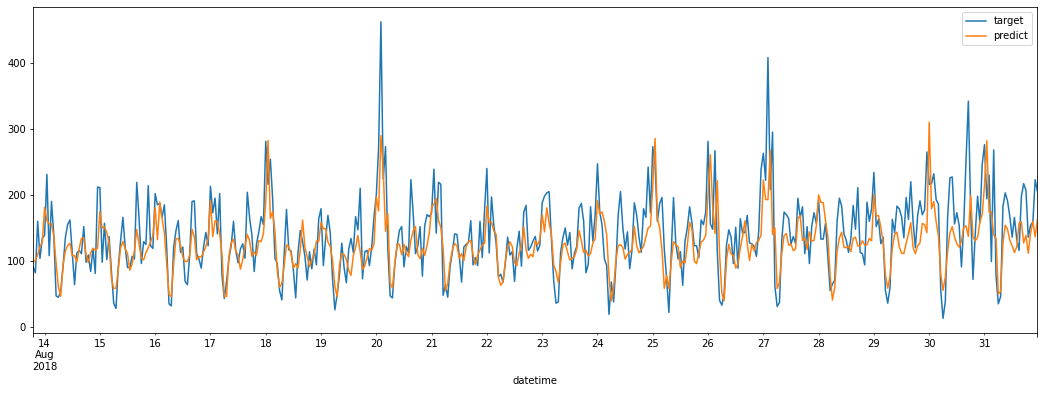

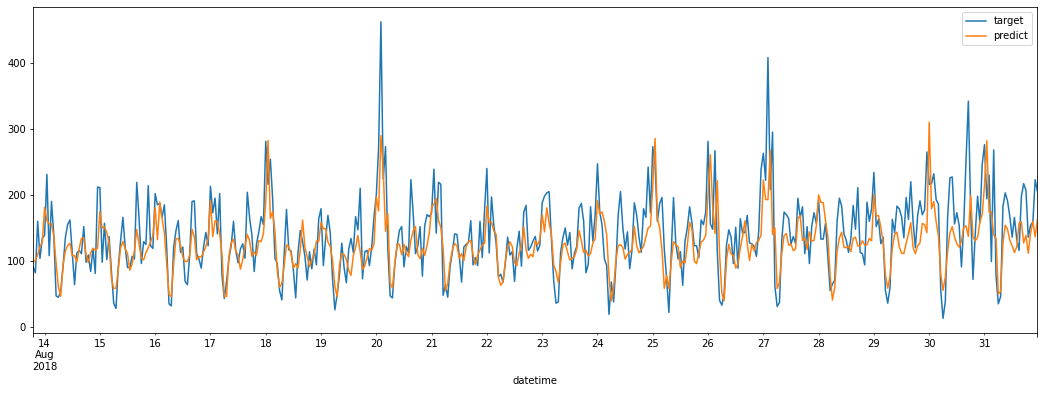

In [27]:
df_viz = pd.DataFrame({"target":y_test, "predict":cb_pred})
df_viz.plot(figsize=(18, 6))
df_viz.plot(figsize=(18, 6))
None

**Вывод:** лучшие показатели у `CatBoostRegressor`

## Итоговой вывод

**Вывод:** полученные данные мы преобразовали, добавив в индекс время. Затем мы проверили данные на пропуски и хронологическую последовательность. Убедившись, что все в порядке, мы ресэмлировали данные по одному часу.

Подготовив данные, мы определили некоторые закономерности. Так, на протяжении всех наблюдений отмечается восходящий тренд по количеству заказов. Особенно он заметен с августа. Также отмечена сезонность, но из-за частоты наблюдений ее тяжело интерпретировать. Для определения сезонности, мы взяли отрезок наблюдений в 1 неделю и выделили, что рост заказов начинается с пятницы и заканчивается в понедельник, количество заказов увеличивается в вечернее время.

Для создания модели мы разбили данные на выборки, определили признаки. При помощи кросс-валидации и гридсерча определили лучшие гиперпараметры. Затем, мы проверили модели на тестовых данных и опредили, что лучшие показатели у `Catboost`